In [304]:
import numpy as np
import pandas as pd
import random
import os

from pyprojroot import here
import seaborn as sns
from matplotlib import pyplot as plt
from mlxtend.plotting import heatmap
from mlxtend.plotting import plot_decision_regions

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import initializers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.losses import BinaryFocalCrossentropy
from tensorflow.keras.metrics import AUC, Recall, Precision,F1Score


import keras_tuner as kt
from keras_tuner import HyperParameters


from sklearn import metrics
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_curve, auc as sk_auc

import wandb
from wandb.integration.keras import WandbCallback
from wandb.integration.keras import WandbModelCheckpoint


random.seed(7)

In [305]:
X_train = pd.read_csv(here('data/processed/X_train_scaled.csv'))
print(X_train.shape)
y_train = pd.read_csv(here('data/processed/Y_train.csv'))
print(y_train.shape)


X_val = pd.read_csv(here('data/processed/X_val_scaled.csv'))
print(X_val.shape)
y_val = pd.read_csv(here('data/processed/Y_val.csv'))
print(y_val.shape)

(7499, 6)
(7499, 6)
(1501, 6)
(1501, 6)


Machine failure
0    1451
1      50
Name: count, dtype: int64


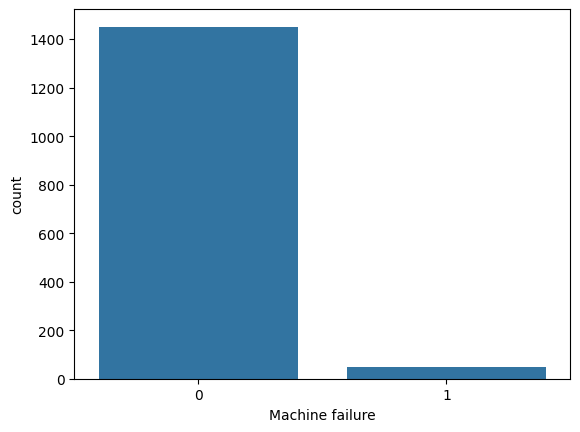

In [306]:
sns.barplot(y_val['Machine failure'].value_counts())
print(y_val['Machine failure'].value_counts())

In [307]:

def target_class_imbalance(target):
    failure_representation = {}

    for mode, s in target.items():  # iterate columns as Series
        pos = int(s.sum())             # assumes 0/1 labels
        total = len(s)
        pct = 100.0 * pos / total
        print(f"Number of positive samples for {mode}, in training data: {pos} ({pct:.2f}% of total)")
        failure_representation[mode] = (pos, pct)
    return failure_representation

dict_of_percentages = target_class_imbalance(y_train)

df = (
    pd.DataFrame.from_dict(
        dict_of_percentages,
        orient="index",
        columns=["Failure_count", "Class_representation"]
    )
    .rename_axis("Failure_mode")
    .reset_index()
)

out_path = here("reports_by_milestone/week_07/class_imbalance_data.csv")
df.to_csv(out_path, index=False)

print(df)


Number of positive samples for Machine failure, in training data: 245 (3.27% of total)
Number of positive samples for TWF, in training data: 36 (0.48% of total)
Number of positive samples for HDF, in training data: 87 (1.16% of total)
Number of positive samples for PWF, in training data: 74 (0.99% of total)
Number of positive samples for OSF, in training data: 66 (0.88% of total)
Number of positive samples for RNF, in training data: 14 (0.19% of total)
      Failure_mode  Failure_count  Class_representation
0  Machine failure            245              3.267102
1              TWF             36              0.480064
2              HDF             87              1.160155
3              PWF             74              0.986798
4              OSF             66              0.880117
5              RNF             14              0.186692


In [308]:
#Setting interested failure mode
y_train_machine_failure = y_train['Machine failure']
y_val_machine_failure = y_val['Machine failure']

In [309]:

# Split the training data by class and defining failure binary class
X_majority = X_train[y_train_machine_failure == 0]
X_minority = X_train[y_train_machine_failure == 1]

# Downsample majority class to match the size of the minority class
X_majority_downsampled, y_majority_downsampled = resample(X_majority, 
                                                           y_train_machine_failure[y_train_machine_failure == 0],
                                                           replace=False,  # no replacement
                                                           n_samples=len(X_minority),  # downsample to the minority count
                                                           random_state=7)

# Combine the downsampled majority class with the minority class
X_train_balanced = np.vstack((X_majority_downsampled, X_minority))
y_train_balanced = np.hstack((y_majority_downsampled, y_train_machine_failure[y_train_machine_failure == 1]))

# Shuffle the balanced training set

X_train_balanced, y_train_balanced = shuffle(X_train_balanced, y_train_balanced, random_state=7)


In [310]:
def build_model(num_features,l2_lambda=.0001):
    """Return a simple logistic regression model using the Keras Sequential API."""
  # Clear session and set a random seed for consistent behavior.
    tf.keras.backend.clear_session()
    tf.random.set_seed(7)
    

  # Use Keras Sequential API to build a logistic regression
    model = keras.Sequential()
    
    # create input layer
    model.add(tf.keras.Input(shape=(num_features,),
         name='Input'
    ))
   
    
    model.add(keras.layers.Dense(
        units=1,  
        use_bias=True,
        activation='sigmoid',
        kernel_initializer=initializers.RandomNormal(stddev=0.01),
        bias_initializer=initializers.RandomNormal(stddev=0.01),
        name="Output",
        kernel_regularizer=regularizers.l2(l2_lambda)
    ))
  
  # Use Binary Crossentropy as our loss and the SGD optimizer.
    #model.compile(
   #     loss= tf.keras.losses.BinaryCrossentropy(),
    #    optimizer= tf.keras.optimizers.SGD(learning_rate=0.01),
     #   metrics= [tf.keras.metrics.BinaryAccuracy()]
    #)
    return model

# Build a model
model = build_model(num_features=X_train.shape[1])


model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Output (Dense)                  │ (None, 1)              │             7 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7 (28.00 B)

 Trainable params: 7 (28.00 B)

 Non-trainable params: 0 (0.00 B)

In [311]:
X_train.shape, y_train_machine_failure.shape

((7499, 6), (7499,))

In [312]:
class WBLogger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        payload = {"epoch": int(epoch)}
        for k, v in logs.items():
            if v is not None:
                try:
                    payload[f"epoch/{k}"] = float(v)
                except Exception:
                    
                    try:
                        payload[f"epoch/{k}"] = float(np.array(v).ravel()[-1])
                    except Exception:
                        pass
        wandb.log(payload)


In [313]:
class build_model_tuner(kt.HyperModel):
    def build(self, hp):
        # Regularization to tune
        l2_lambda = hp.Float("l2_lambda", 1e-6, 1e-2, sampling="log")

        
        model = build_model(num_features=X_train.shape[1], l2_lambda=l2_lambda)

        # Optimizer tune
        opt_name = hp.Choice("optimizer", ["sgd", "adam", "adamw", "rmsprop", "nadam"])
        lr = hp.Choice("learning_rate", [0.01, 0.001, 0.0001, 0.0002, 0.025])

        if opt_name == "sgd":
            momentum = hp.Choice("momentum", [0.0, 0.9])
            optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=momentum)
        elif opt_name == "adam":
            optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
        elif opt_name == "adamw":
            wd = hp.Float("weight_decay", 1e-6, 1e-2, sampling="log")
            optimizer = tf.keras.optimizers.AdamW(learning_rate=lr, weight_decay=wd)
        elif opt_name == "rmsprop":
            rho = hp.Choice("rho", [0.9, 0.95, 0.99])
            optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr, rho=rho)
        else:
            optimizer = tf.keras.optimizers.Nadam(learning_rate=lr)

        #Attempting to penalize minority errors
        focal_alpha = hp.Float("focal_alpha", 0.50, 0.95, step=0.05)
        focal_gamma = hp.Choice("focal_gamma", [1.0, 1.5, 2.0, 2.5])

        model.compile(
            optimizer=optimizer,
            loss=BinaryFocalCrossentropy(alpha=focal_alpha, gamma=focal_gamma, from_logits=False),
            metrics=[
                AUC(curve="PR",  name="pr_auc"),
                Recall(name="recall_pos", thresholds=0.60),
                Precision(name="precision_pos", thresholds=0.60),
                AUC(curve="ROC", name="auc"),
                F1Score(name="f1_score", threshold=0.50), 
            ],
        )
        return model

    def fit(self, hp, model, x, y, **kwargs):
        run = wandb.init(
            project="predictive-maintenance",
            name=f"60-thresh-tune-regularization-opt-decay-lr-{wandb.util.generate_id()}",
            config=hp.values,
            reinit=True,
        )
        try:
            epochs = hp.Choice("epochs", [200, 300, 350, 400, 500])

            os.makedirs("models", exist_ok=True)
            ckpt_path = os.path.join("models", f"{run.id}-best.keras")

            cb = list(kwargs.pop("callbacks", []))
            cb += [
                ModelCheckpoint(
                    ckpt_path,
                    monitor="val_loss", mode="min",
                    save_best_only=True, save_weights_only=False,
                ),
                EarlyStopping(
                    monitor="val_loss", mode="min",
                    patience=20, restore_best_weights=True,
                ),
                WBLogger(),  
            ]

            history = model.fit(
                x, y,
                epochs=epochs,
                validation_data=(X_val, y_val_machine_failure),
                callbacks=cb,
                **kwargs
            )

          
            val_f1 = history.history.get("val_f1_score", [None])[-1]
            if val_f1 is not None:
                try:
                    val_f1 = float(val_f1)
                except Exception:
                    val_f1 = float(np.array(val_f1).ravel()[-1])

            
            y_prob = model.predict(X_val, verbose=0).ravel()
            fpr, tpr, _ = roc_curve(y_val_machine_failure, y_prob)
            roc_auc = sk_auc(fpr, tpr)

            wandb.summary["val/auc_roc"] = float(roc_auc)
            if val_f1 is not None:
                wandb.summary["val/f1"] = val_f1

            # Log best SavedModel as a W&B model artifact
            meta = {
                "val_auc": float(roc_auc),
                "val_f1": val_f1,
                "l2_lambda": float(hp.get("l2_lambda")),
                "optimizer": hp.get("optimizer"),
                "learning_rate": float(hp.get("learning_rate")),
                "focal_alpha": float(hp.get("focal_alpha")),
                "focal_gamma": float(hp.get("focal_gamma")),
                "framework": "tf.keras",
                "format": "keras_v3",
            }
            art = wandb.Artifact("machine-failure-60-threshold", type="model", metadata=meta)
            art.add_file(ckpt_path)
            run.log_artifact(art, aliases=["latest", "trial-best"])

            return history
        finally:
            wandb.finish()

In [314]:
tuner = kt.BayesianOptimization(
    build_model_tuner(),
    objective=kt.Objective("val_loss", "min"),
    max_trials=50,
    num_initial_points=20,
    seed=7,
    directory=".",
    project_name="predictive-maintenance",
)

tuner.search(X_train, y_train_machine_failure)



Trial 50 Complete [00h 00m 14s]
val_loss: 0.030837280675768852

Best val_loss So Far: 0.019188273698091507
Total elapsed time: 00h 29m 12s
